In [10]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the data
# link to the data below - https://drive.google.com/open?id=1GAVoYBwtb4TK-XaCzgYvUePIvjf-acku
data_raw = pd.read_pickle('./features/data_features_csv-2017.pkl')
data_raw.head(2)

,id,original,number,cdate,tcdate,tmdate,ddate,content,forum,referent,...,details,title,authors,abstract,keywords,replyCount,label,ref_latest,ref_len,ref_years
HJWHIKqgl,HJWHIKqgl,None,494,None,1478297149874,1559850667018,None,{'paperhash': 'sutherland|generative_models_an...,HJWHIKqgl,None,...,{'replyCount': 12},Generative Models and Model Criticism via Opti...,"[Dougal J. Sutherland, Hsiao-Yu Tung, Heiko St...",We propose a method to optimize the representa...,[Unsupervised Learning],12,Accept,2019,34,"[2008, 2016, 2011, 2015, 2015, 2008, 2014, 200..."
SyK00v5xx,SyK00v5xx,None,448,None,1478291152993,1544202244497,None,{'paperhash': 'arora|a_simple_but_toughtobeat_...,SyK00v5xx,None,...,{'replyCount': 19},A Simple but Tough-to-Beat Baseline for Senten...,"[Sanjeev Arora, Yingyu Liang, Tengyu Ma]",\nThe success of neural network methods for co...,"[Natural language processing, Unsupervised Lea...",19,Accept,2016,49,"[2012, 2012, 2013, 2013, 2014, 2015, 2016, 200..."


# Preprocessing

#### Contains ML keywords:

In [12]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

#### Contains state-of-the-art

In [13]:
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

#### Glove vec average:

In [14]:
embeddings_dict = {}

with open("/home/shruti/data/glove/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

#### Avg sentence length of abstract

In [17]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length

#### Number of recent references (last 5 year)

In [18]:
def get_num_recent_refs(list_refs):
    count = 0
    for i in list_refs:
        if int(i) >= 2012:
            count += 1
    return count

#### Loading the new features dict

In [19]:
new_features_from_text = None
with open('./OCR_workspace/feature_dict/2017_features.pkl', "rb") as f:
    new_features_from_text = pickle.load(f)

#### Loading the count of ICLR references featres dict

In [20]:
iclr_refs_count = None
with open('./OCR_workspace/feature_dict/iclr_refs_count.pkl', 'rb') as f:
    iclr_refs_count = pickle.load(f)

#### Avg. ref mention length in chars

In [21]:
def get_avg_ref_mention_length(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "avg_ref_mention" in new_features_from_text[pid]:
            return new_features_from_text[pid]["avg_ref_mention"]
        else:
            print("Missing avg_ref_mention for: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Number of sections

In [22]:
def get_num_sections(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "num_sections" in new_features_from_text[pid]:
            return new_features_from_text[pid]["num_sections"]
        else:
            return 4
    else:
        print("Missing pid for ", pid)
        return 4

#### Contains appendix

In [23]:
def contains_appendix(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "contains_appendix" in new_features_from_text[pid]:
            return new_features_from_text[pid]["contains_appendix"]
        else:
            print("Key contains_appendix not present: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Count of tables, equations, figures

In [24]:
def get_count_of_fig_table_eqn(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and "eqn_ref_count" in new_features_from_text[pid] and "fig_ref_count" in new_features_from_text[pid]:
            total_count = new_features_from_text[pid]["table_ref_count"] + new_features_from_text[pid]["fig_ref_count"] + new_features_from_text[pid]["eqn_ref_count"]
            return total_count
        else:
            print("Keys  count_of_fig_table_eqn keys missing for ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### contains table

In [32]:
def contains_table(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["table_ref_count"] and new_features_from_text[pid]["table_ref_count"]>0:
            return 1
    return 0

#### Contains equation(s)

In [33]:
def contains_equation(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "eqn_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["eqn_ref_count"] and new_features_from_text[pid]["eqn_ref_count"]>0:
            return 1
    return 0

#### Contains figure(s)

In [34]:
def contains_figure(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "fig_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["fig_ref_count"] and new_features_from_text[pid]["fig_ref_count"]>0:
            return 1
    return 0

#### Count of ICLR references

In [35]:
def get_iclr_refs_count(id):
    year = 2017
    pid = "2017_" + id
    if pid in iclr_refs_count:
        return iclr_refs_count[pid]
    return 0

### Feature Matrix Creation

In [65]:
data = pd.DataFrame()
data_raw = data_raw[data_raw['label']!='Invite']
data['id'] = data_raw['id']#.value_counts()
data['n_authors'] = data_raw['authors'].apply(len)#.value_counts()
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
data['avg_sent_len'] = data_raw['abstract'].apply(avg_abs_sent_length)
data['abs_glove_avg'] = data_raw['abstract'].apply(get_glove_avg)
data['contains_sota'] = data_raw['abstract'].apply(sota_present)
#data.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/data/data-2017-20.pkl')

In [66]:
data['num_recent_refs'] = data_raw['ref_years'].apply(get_num_recent_refs)
data['avg_ref_length'] = data_raw['id'].apply(get_avg_ref_mention_length)
data['num_sections'] = data_raw['id'].apply(get_num_sections)
data['contains_appendix'] = data_raw['id'].apply(contains_appendix)
data['fig_tab_eqn_count'] = data_raw['id'].apply(get_count_of_fig_table_eqn)
data['contains_table'] = data_raw['id'].apply(contains_table)
data['contains_figure'] = data_raw['id'].apply(contains_figure)
data['contains_equation'] = data_raw['id'].apply(contains_equation)
data['iclr_references'] = data_raw['id'].apply(get_iclr_refs_count)


data['label'] = data_raw['label']

data.head(2)

Key contains_appendix not present:  r1Usiwcex


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HJWHIKqgl,HJWHIKqgl,7,76,10,996,160,1,34,2019,1,...,21,216,6,1,0,0,1,0,3,Accept
SyK00v5xx,SyK00v5xx,3,59,8,1611,253,2,49,2016,1,...,35,28,12,1,10,1,1,1,1,Accept


In [67]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label


In [94]:
data.to_pickle('./features/all_data_features_csv_2017_new.pkl')

In [87]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)

In [88]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
  dot_data = StringIO()
  tree.export_graphviz(clf[0], 
  out_file=dot_data, 
  class_names=['Accept','Reject'], # the target names.
  feature_names=X.columns, # the feature names.
  filled=True, # Whether to fill in the boxes with colours.
  rounded=True, # Whether to round the corners of the boxes.
  special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return Image(graph.create_png())

# All models

In [89]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

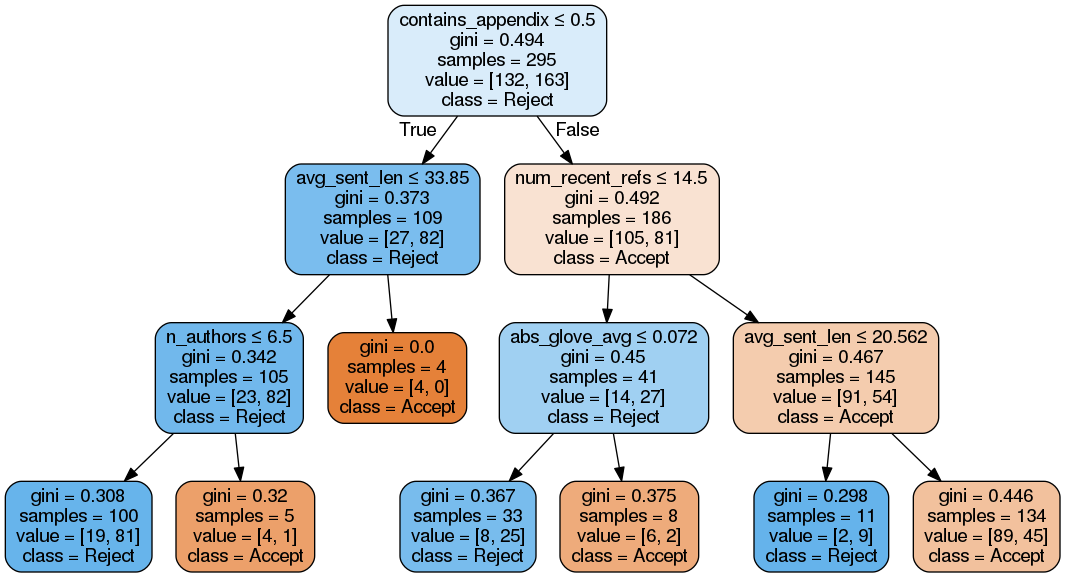

In [90]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
  X = data.drop(columns=['id','label'])
  y = data['label']
  results = cross_validate(clf, X, y, return_estimator=True)
  clf = results['estimator']
  results.pop('estimator')
  accuracy = np.mean(results['test_score'])
  model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
  if clf_name == 'DecisionTree':
    display(plot(clf))

In [91]:
# Model results with all the new features without normalization
model_results

,Accuracy,CVresults
RandomForest,0.595958,"{'fit_time': [0.017012596130371094, 0.00970125..."
DecisionTree,0.584728,"{'fit_time': [0.0021431446075439453, 0.0020916..."
RidgeClf,0.638904,"{'fit_time': [0.004420757293701172, 0.00370192..."
KNN,0.5057,"{'fit_time': [0.002615690231323242, 0.00254273..."
GaussianProcessClf,0.514739,"{'fit_time': [0.10168957710266113, 0.201512575..."
GaussNB,0.643347,"{'fit_time': [0.004263639450073242, 0.00409555..."
NeuralNet,0.559815,"{'fit_time': [0.4534769058227539, 0.4280405044..."
LogisticR,0.643424,"{'fit_time': [0.014331340789794922, 0.01160144..."
SVC,0.553043,"{'fit_time': [0.015288352966308594, 0.01434087..."
LogisticLassoR,0.641141,"{'fit_time': [0.03127861022949219, 0.026750087..."


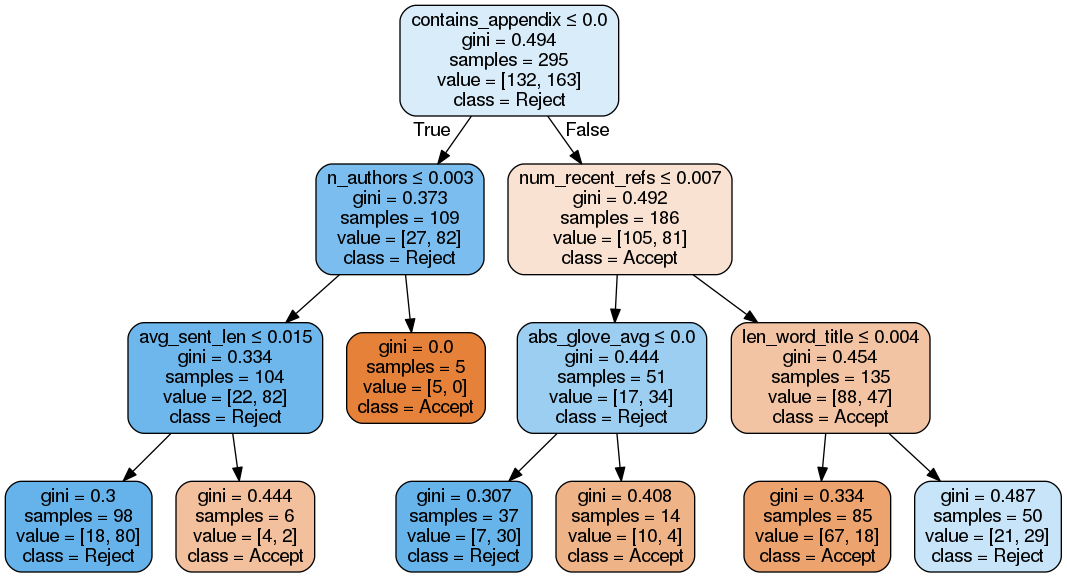

In [92]:
# Model results with all the new features with normalization
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

#X = data.drop(columns=['id','label'])
#X = data.drop(columns=['id','label', 'contains_equation', 'contains_table', 'contains_figure'])

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))
#     X = data.drop(columns=['id','label']
#     y = data['label']
#     X_normalized = normalize(X)
#     results = cross_validate(clf, X_normalized, y, return_estimator=True)
#     clf = results['estimator']
#     results.pop('estimator')
#     accuracy = np.mean(results['test_score'])
#     model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))


In [93]:
model_results

,Accuracy,CVresults
RandomForest,0.573466,"{'fit_time': [0.009111404418945312, 0.00874495..."
DecisionTree,0.58701,"{'fit_time': [0.0016658306121826172, 0.0016067..."
RidgeClf,0.553043,"{'fit_time': [0.0032753944396972656, 0.0019793..."
KNN,0.512487,"{'fit_time': [0.0009036064147949219, 0.0008864..."
GaussianProcessClf,0.553043,"{'fit_time': [1.7917203903198242, 1.3819715976..."
GaussNB,0.643378,"{'fit_time': [0.012610197067260742, 0.00201725..."
NeuralNet,0.553043,"{'fit_time': [0.061434030532836914, 0.04442906..."
LogisticR,0.553043,"{'fit_time': [0.0031425952911376953, 0.0025987..."
SVC,0.553043,"{'fit_time': [0.011078119277954102, 0.01112174..."
LogisticLassoR,0.553043,"{'fit_time': [0.0026831626892089844, 0.0021121..."


### To update in md format

In [56]:
# Copy the results into .md file to visualize the table in .md
model_results.drop(columns=['CVresults']).to_html().replace('\n','')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Accuracy</th>    </tr>  </thead>  <tbody>    <tr>      <th>RandomForest</th>      <td>0.582491</td>    </tr>    <tr>      <th>DecisionTree</th>      <td>0.589278</td>    </tr>    <tr>      <th>RidgeClf</th>      <td>0.553043</td>    </tr>    <tr>      <th>KNN</th>      <td>0.512487</td>    </tr>    <tr>      <th>GaussianProcessClf</th>      <td>0.553043</td>    </tr>    <tr>      <th>GaussNB</th>      <td>0.656892</td>    </tr>    <tr>      <th>NeuralNet</th>      <td>0.553043</td>    </tr>    <tr>      <th>LogisticR</th>      <td>0.553043</td>    </tr>    <tr>      <th>SVC</th>      <td>0.553043</td>    </tr>    <tr>      <th>LogisticLassoR</th>      <td>0.553043</td>    </tr>  </tbody></table>'